In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, shutil, logging, gc
import h5py, pickle
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum
from darkhistory.history.reionization import alphaA_recomb
from darkhistory.history.tla import compton_cooling_rate

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.spectrum import AttenuatedSpectrum
from dm21cm.interpolators_jax import SFRDInterpolator
from dm21cm.dm_params import DMParams

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
z_start = 45.
z_end = 5.
zplusone_step_factor = 1.001
dm_params = DMParams(
    mode='decay',
    primary='phot_delta',
    m_DM=1e8, # [eV]
    lifetime=1e50, # [s]
)
enable_elec = False

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 32,
        BOX_LEN = 32*2, # [conformal Mpc]
        N_THREADS = 32,
        USE_INTERPOLATION_TABLES = True, # for testing
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 54321,
    write = True,
)

clear_cache = True
use_tqdm = True
debug_break_after_z = 10.
debug_record_extra = False

# 21cmFAST xray injection
use_21cmfast_xray = False
astro_params_before_step = p21c.AstroParams(L_X = 0.) # log10 value
debug_turn_off_pop2ion = True
debug_xray_Rmax_p21c = 500.

# DM21cm xray injection
debug_flags = ['xc-ots', 'xc-custom-SFRD', 'xc-01attenuation']
debug_unif_delta_dep = True
debug_unif_delta_tf_param = True
st_multiplier = 10.
debug_nodplus1 = True
debug_xray_Rmax_shell = 500.
debug_xray_Rmax_bath = 500.
adaptive_shell = 40

# defaults
tf_on_device = True
debug_depallion = False
debug_use_21_totinj = None

In [3]:
from dm21cm.evolve import get_z_edges, split_xray, gen_injection_boxes, p21c_step, geom_inds, get_emissivity_bracket, DepTracker, debug_get_21totf_interp

In [4]:
def custom_SFRD(z, delta, r):
    return 1. + delta

In [5]:
source_cache_dir = os.environ['P21C_CACHE_DIR'] + "/stepinit_dc_xdecay_ion_z10"

In [9]:
#===== data and cache =====
os.environ['DM21CM_DATA_DIR'] = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf001/data'
data_dir = os.environ['DM21CM_DATA_DIR']
cache_dir = "/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/step_working"
p21c.config['direc'] = cache_dir
os.makedirs(p21c.config['direc'], exist_ok=True)
gc.collect()

#===== initialize =====
#--- physics parameters ---
EPSILON = 1e-6
p21c.global_params.Z_HEAT_MAX = z_start + EPSILON
p21c.global_params.ZPRIME_STEP_FACTOR = zplusone_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.
if debug_turn_off_pop2ion:
    p21c.global_params.Pop2_ion = 0.
if debug_xray_Rmax_p21c is not None:
    p21c.global_params.R_XLy_MAX = debug_xray_Rmax_p21c

abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
if not np.isclose(np.log(zplusone_step_factor), abscs['dlnz']):
    raise ValueError('zplusone_step_factor and abscs mismatch')
dm_params.set_inj_specs(abscs)

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
tf_wrapper = TransferFunctionWrapper(
    box_dim = box_dim,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = enable_elec,
    on_device = tf_on_device,
)

#--- xraycheck ---
shutil.copyfile(f"{source_cache_dir}/xraycheck_brightness.h5", f"{p21c.config['direc']}/xraycheck_brightness.h5")
delta_cacher = Cacher(
    data_path=f"{p21c.config['direc']}/xraycheck_brightness.h5",
    cosmo=cosmo, N=box_dim, dx=box_len/box_dim,
    shell_Rmax=debug_xray_Rmax_shell,
    Rmax=debug_xray_Rmax_bath,
)
# reconstruct spec cache
shutil.copyfile(f"{source_cache_dir}/spec_cache.p", f"{p21c.config['direc']}/spec_cache.p")
spec_cache = pickle.load(open(f"{source_cache_dir}/spec_cache.p", 'rb'))
delta_cacher.spectrum_cache = spec_cache
delta_cacher.brightness_cache.z_s = spec_cache.z_s
    
xray_eng_lo = 0.5 * 1000 # [eV]
xray_eng_hi = 10.0 * 1000 # [eV]
xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)

sfrd_tables = load_h5_dict(f"{data_dir}/sfrd_tables.h5")
z_range = sfrd_tables['z_range']
delta_range = sfrd_tables['delta_range']
r_range = sfrd_tables['r_range']
cond_sfrd_table = sfrd_tables['cond_sfrd_table']
st_sfrd_table = sfrd_tables['st_sfrd_table']
Cond_SFRD_Interpolator = SFRDInterpolator(z_range, delta_range, r_range, cond_sfrd_table) # jax good
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table * st_multiplier)

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

records = []
records_extra = []

#===== main loop =====
#--- trackers ---
i_xraycheck_shell_start = ... # set later
i_xraycheck_bath_start = ... # set later

z_edges = z_edges[1:] # Maybe fix this later
z_range = range(len(z_edges)-1)
print_str = ''
dep_tracker = DepTracker()

INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.


In [10]:
perturbed_field = p21c.perturb_field(redshift=z_edges[1], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21c_step(
    perturbed_field=perturbed_field, spin_temp=None, ionized_box=None, astro_params=astro_params_before_step
)

zp = 4.495863e+01 E_tot_ave = 0.000000e+00
zp = 4.491272e+01 E_tot_ave = 0.000000e+00
zp = 4.495863e+01 E_tot_ave = 0.000000e+00


## Recover state

In [11]:
# get TsBox IonizedBox dictionaries

tsfiles = [fn for fn in os.listdir(source_cache_dir) if fn.startswith('TsBox')]
ibfiles = [fn for fn in os.listdir(source_cache_dir) if fn.startswith('IonizedBox')]

reload_z_s = False

if reload_z_s:
    ts_z_s = []
    for tsfn in tqdm(tsfiles):
        with h5py.File(source_cache_dir + "/" + tsfn, 'r') as hf:
            ts_z_s.append(hf.attrs['redshift'])

    ib_z_s = []
    for ibfn in tqdm(ibfiles):
        with h5py.File(source_cache_dir + "/" + ibfn, 'r') as hf:
            ib_z_s.append(hf.attrs['redshift'])
    pickle.dump((ts_z_s, ib_z_s), open(f"{source_cache_dir}/z_s.p", 'wb'))
else:
    ts_z_s, ib_z_s = pickle.load(open(f"{source_cache_dir}/z_s.p", 'rb'))

def fn_from_z(fns, z_s, z, verbose=False):
    ind = np.argmin(np.abs(np.array(z_s) - z))
    if verbose:
        print(f'Got file {fns[ind]} at z = {z_s[ind]} from prompt z = {z}')
    return fns[ind]

In [13]:
last_tsfn = fn_from_z(tsfiles, ts_z_s, 0, verbose=True)
last_ibfn = fn_from_z(ibfiles, ib_z_s, 0, verbose=True)

Got file TsBox_e6c6d260b76b862292f2f15071eb948f_r54321.h5 at z = 9.99517643894902 from prompt z = 0
Got file IonizedBox_248a91ceea3b359ed7677fe1da362592_r54321.h5 at z = 9.99517643894902 from prompt z = 0


In [18]:
shutil.copyfile(f"{source_cache_dir}/{last_tsfn}", f"{cache_dir}/TsBox_init.h5")
shutil.copyfile(f"{source_cache_dir}/{last_ibfn}", f"{cache_dir}/IonizedBox_init.h5")

'/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/step_working/IonizedBox_init.h5'

In [15]:
z_stopped = np.min(ts_z_s)
i_z = np.searchsorted(-z_edges, -z_stopped)
print(i_z, z_edges[i_z], z_stopped)

1431 9.99517643894902 9.99517643894902


## 21cmFAST step

In [19]:
print(cache_dir)

/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/step_working


In [20]:
# TsBox
last_TsBox_dict = {}
with h5py.File(cache_dir + "/TsBox_init.h5", 'r') as hf:
    for k in hf['TsBox'].keys():
        last_TsBox_dict[k] = hf['TsBox'][k][()]

spin_temp.J_21_LW_box = last_TsBox_dict['J_21_LW_box']
spin_temp.x_e_box = last_TsBox_dict['x_e_box']
spin_temp.Tk_box = last_TsBox_dict['Tk_box']
spin_temp.Ts_box = last_TsBox_dict['Ts_box']
spin_temp.astro_params = p21c.AstroParams(L_X = 40.)
spin_temp.redshift = z_edges[i_z]

In [21]:
# IonizedBox
last_IonizedBox_dict = {}
with h5py.File(cache_dir + "/IonizedBox_init.h5", 'r') as hf:
    for k in hf['IonizedBox'].keys():
        last_IonizedBox_dict[k] = hf['IonizedBox'][k][()]
ionized_box.xH_box = last_IonizedBox_dict['xH_box']
#ionized_box.z_re_box = last_IonizedBox_dict['z_re_box']
ionized_box.astro_params = p21c.AstroParams(L_X = 40.)
ionized_box.redshift = z_edges[i_z]

In [22]:
perturbed_field = p21c.perturb_field(redshift=z_edges[i_z+1], init_boxes=p21c_initial_conditions)

In [23]:
spin_temp_next = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    previous_spin_temp = spin_temp,
    input_heating_box = None,
    input_ionization_box = None,
    input_jalpha_box = None,
    astro_params = p21c.AstroParams(L_X = 40.),
    write=True,
)

zp = 9.984192e+00 E_tot_ave = 3.872371e-04


In [24]:
ionized_box_next = p21c.ionize_box(
    perturbed_field = perturbed_field,
    previous_ionize_box = ionized_box,
    spin_temp = spin_temp_next,
    astro_params = p21c.AstroParams(L_X = 40.),
    write=True,
)
brightness_temp_next = p21c.brightness_temperature(
    ionized_box = ionized_box_next,
    perturbed_field = perturbed_field,
    spin_temp = spin_temp_next,
    write=True,
)

In [27]:
def r_vals_pc(BOX_LEN=64, HII_DIM=32, Rmax=p21c.global_params.R_XLy_MAX, n=p21c.global_params.NUM_FILTER_STEPS_FOR_Ts):
    L_FACTOR = 0.620350491
    R = L_FACTOR * BOX_LEN/HII_DIM
    R_factor = pow(Rmax/R, 1/n)
    r_vals = R * R_factor ** np.arange(n)
    return r_vals

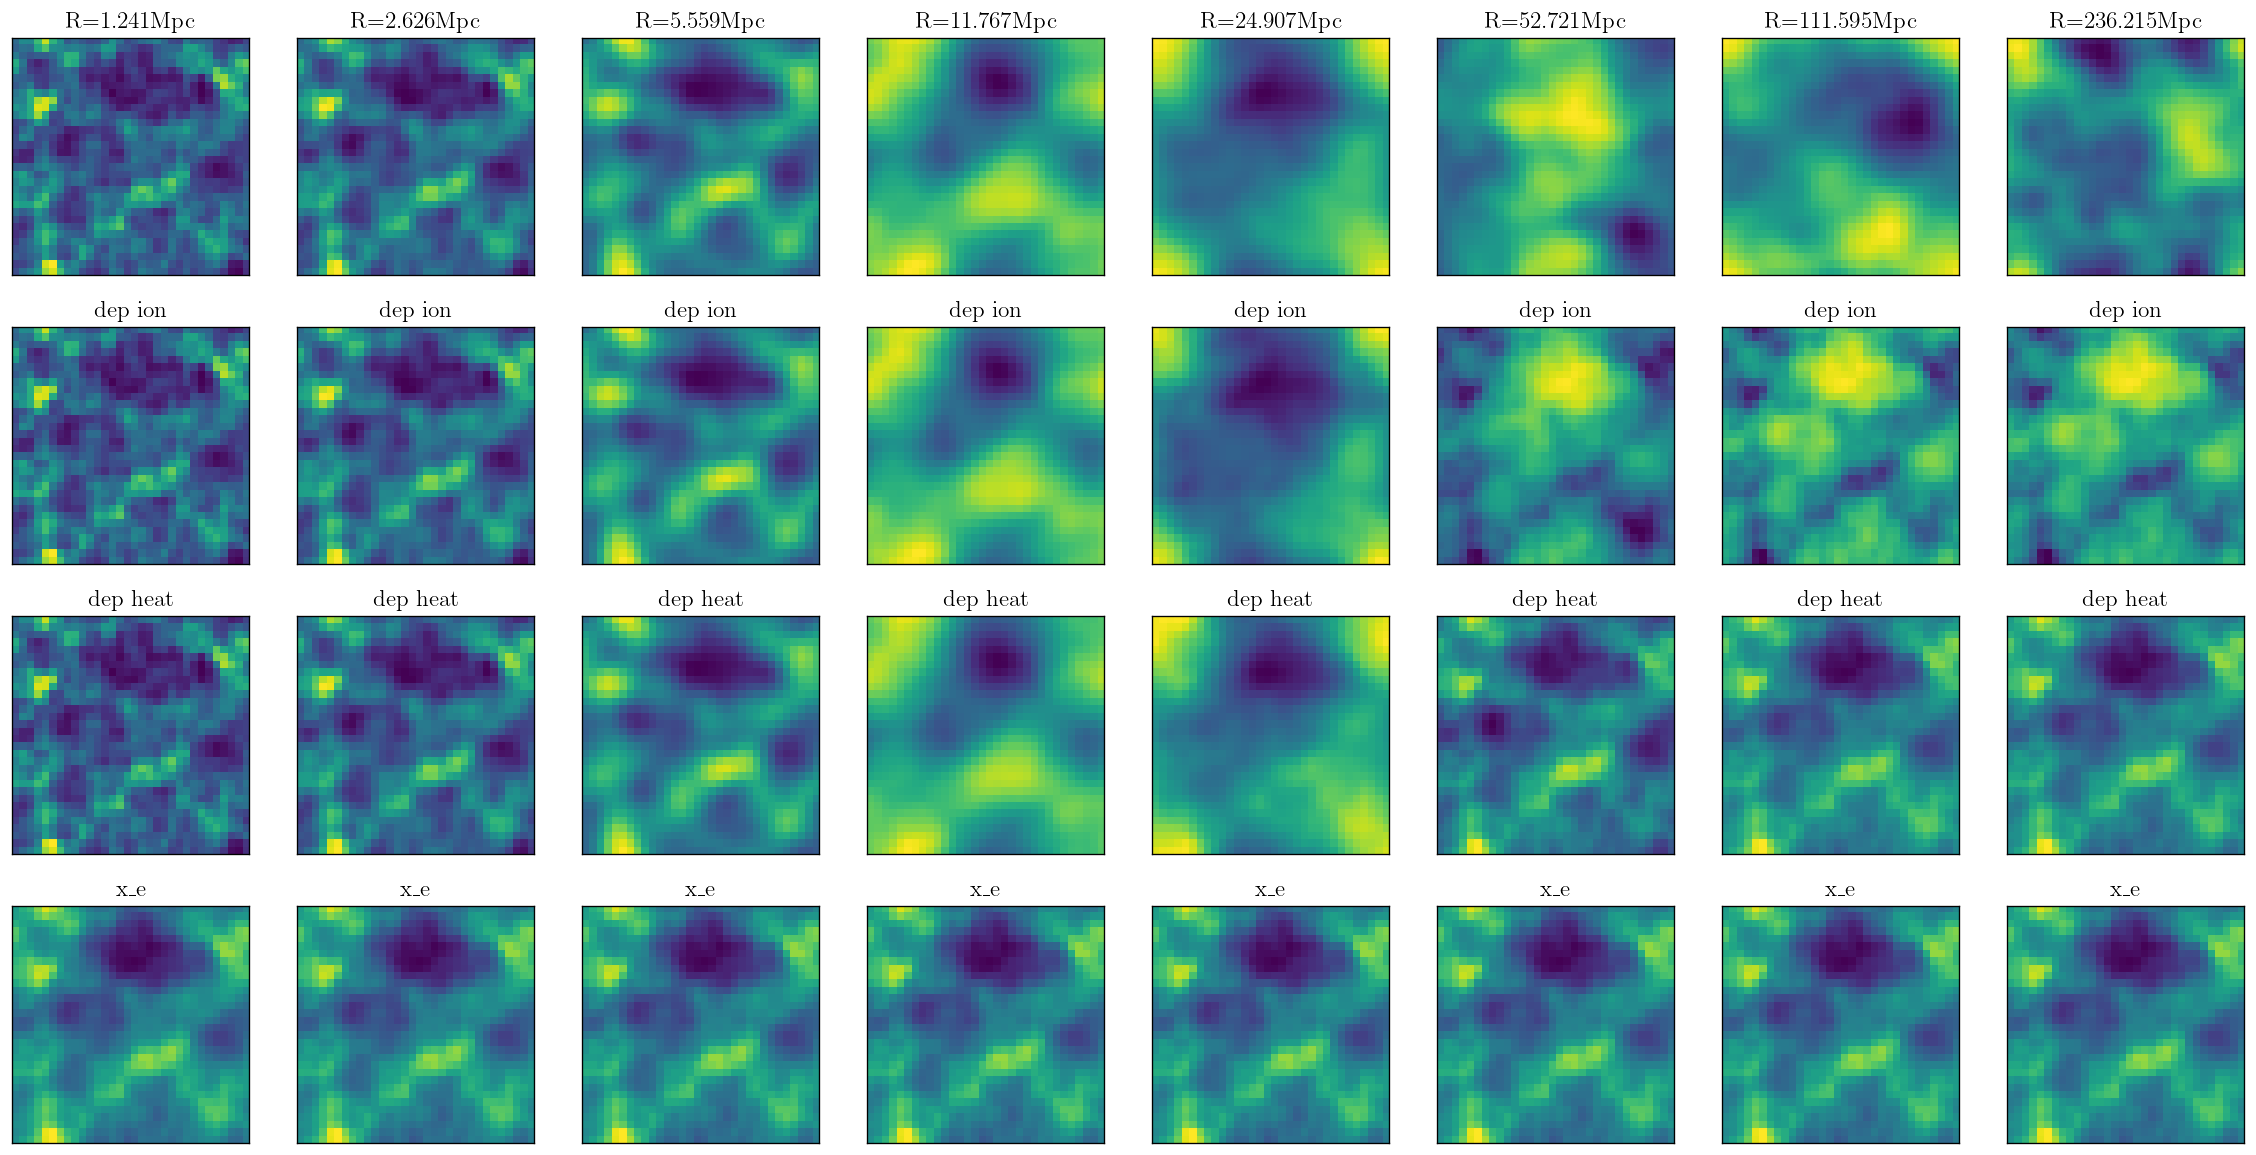

In [33]:
r_vals = r_vals_pc()
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for i in range(8):
    ax = axs[0, i]
    i_sh = i*5
    ax.imshow(spin_temp_next.SmoothedDelta[i_sh][0], origin='lower')
    ax.set(title=f"R={r_vals[i_sh]:.3f}Mpc")

    ax = axs[1, i]
    ax.imshow(spin_temp_next.DepIonBox[i_sh][0], origin='lower')
    ax.set(title="dep ion")

    ax = axs[2, i]
    ax.imshow(spin_temp_next.DepHeatBox[i_sh][0], origin='lower')
    ax.set(title="dep heat")

    ax = axs[3, i]
    ax.imshow(spin_temp_next.x_e_box[0], origin='lower')
    ax.set(title='x_e')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    

## DM21cm step

In [116]:
class DepTracker:
    def __init__(self):
        self.deltas = []
        self.dep_Hion_shells = []
        self.dep_Heion_shells = []
        self.dep_heat_shells = []
        self.R_shells = []
    
    def record(self, dep_box, R=None, delta=None):
        dep_Hion = dep_box[...,0] - self.dep_Hion_before
        dep_Heion = dep_box[...,1] - self.dep_Heion_before
        dep_heat = dep_box[...,3] - self.dep_heat_before
        self.dep_Hion_shells.append(dep_Hion)
        self.dep_Heion_shells.append(dep_Heion)
        self.dep_heat_shells.append(dep_heat)
        self.R_shells.append(R)
        self.deltas.append(delta)
    
    def reset(self, dep_box):
        self.dep_Hion_before = dep_box[...,0]
        self.dep_Heion_before = dep_box[...,1]
        self.dep_heat_before = dep_box[...,3]

    def clear(self):
        self.__init__()

    def get_record(self):
        return {
            'Hion' : np.array(self.dep_Hion_shells),
            'Heion' : np.array(self.dep_Heion_shells),
            'heat' : np.array(self.dep_heat_shells),
            'R' : np.array(self.R_shells),
        }

class DummyBox:
    def __init__(self):
        self.input_heating = np.zeros((32, 32, 32))
        self.input_ionization = np.zeros((32, 32, 32))
        self.input_jalpha = np.zeros((32, 32, 32))

In [117]:
phys.conformal_dx_between_z(12.3, 10)
np.searchsorted(-z_edges, -12.3)

1241

In [118]:
i_xraycheck_shell_start = np.searchsorted(-z_edges, -12.3)

In [119]:
dep_tracker = DepTracker()

z_current = z_edges[i_z]
z_next = z_edges[i_z+1]
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))

nBavg = phys.n_B * (1+z_current)**3 # [Bavg / (physical cm)^3]
delta_plus_one_box = 1 + np.asarray(perturbed_field.density)
rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+z_current)**3 # [eV/(physical cm)^3]
x_e_box = np.asarray(spin_temp.x_e_box)
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+z_current) / nBavg # [inj/Bavg]

x_e_box_tf = x_e_box
if debug_unif_delta_tf_param:
    delta_plus_one_box_tf = jnp.full_like(delta_plus_one_box, 1.)
else:
    delta_plus_one_box_tf = delta_plus_one_box
tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = delta_plus_one_box_tf,
    x_e_box = x_e_box_tf,
)

#===== photon injection and energy deposition =====
xraycheck_bath_toteng_arr = []

#----- older shells: dense -----
if adaptive_shell is None:
    print('shell:', i_xraycheck_shell_start, i_z, flush=True)
    for i_z_shell in range(i_xraycheck_shell_start, i_z):

        delta, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher.get_annulus_data(
            z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
        )
        
        if 'xc-custom-SFRD' in debug_flags:
            delta = jnp.array(delta)
            cond_sfrd = custom_SFRD
        else:
            delta = np.clip(delta, -1.0+EPSILON, np.max(delta_range)-EPSILON)
            delta = jnp.array(delta)
            cond_sfrd = Cond_SFRD_Interpolator
        emissivity_bracket = get_emissivity_bracket(
            z=z_donor, delta=delta, R=R2, dt = dt,
            debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
        ) # [Msun / Bavg]

        dep_tracker.reset(tf_wrapper.dep_box)
        if np.mean(emissivity_bracket) != 0.:
            tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
        dep_tracker.record(tf_wrapper.dep_box, R=phys.conformal_dx_between_z(z_donor, z_current), delta=delta)

        if xraycheck_is_box_average:
            i_xraycheck_shell_start = max(i_z_shell+1, i_xraycheck_shell_start)

#----- older shells: adaptive -----
else:
    i_max = i_z - i_xraycheck_shell_start
    inds_increasing = geom_inds(i_max=i_max, i_transition=10, n_goal=adaptive_shell)
    inds_shell = i_z - inds_increasing
    print('adaptive shell:', inds_shell, flush=True)

    accumulated_shell_N = np.zeros_like(abscs['photE']) # [ph / Bavg]

    for i_z_shell in range(i_xraycheck_shell_start, i_z):

        z_shell = z_edges[i_z_shell]

        #--- for all shells ---
        shell_N = np.array(delta_cacher.spectrum_cache.get_spectrum(z_shell).N) # [ph / Msun]
        if 'xc-custom-SFRD' in debug_flags:
            cond_sfrd = custom_SFRD
        else:
            cond_sfrd = Cond_SFRD_Interpolator
        emissivity_bracket = get_emissivity_bracket(
            z=z_shell, delta=0., R=phys.conformal_dx_between_z(z_shell, z_current), dt=dt,
            debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
        ) # [Msun / Bavg] # get average

        accumulated_shell_N += shell_N * emissivity_bracket # [ph / Bavg]
        if i_z_shell not in inds_shell:
            continue

        #--- now, the chosen ones ---
        delta, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher.get_annulus_data(
            z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
        )
        
        if 'xc-custom-SFRD' in debug_flags:
            delta = jnp.array(delta)
            cond_sfrd = custom_SFRD
        else:
            delta = np.clip(delta, -1.0+EPSILON, np.max(delta_range)-EPSILON)
            delta = jnp.array(delta)
            cond_sfrd = Cond_SFRD_Interpolator
        emissivity_bracket = get_emissivity_bracket(
            z=z_donor, delta=delta, R=R2, dt=dt,
            debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
        ) # [Msun / Bavg]
        # use averaged spectrum: this step already counted
        if np.mean(emissivity_bracket) != 0.:
            emissivity_bracket /= np.mean(emissivity_bracket)

        dep_tracker.reset(tf_wrapper.dep_box)
        if np.mean(emissivity_bracket) != 0.:
            inj_spec = Spectrum(abscs['photE'], accumulated_shell_N, spec_type='N', rs=1+z_current) # [ph / Bavg]
            tf_wrapper.inject_phot(inj_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
        dep_tracker.record(tf_wrapper.dep_box, R=phys.conformal_dx_between_z(z_shell, z_current), delta=delta)

        accumulated_shell_N *= 0. # clear after injection

        if xraycheck_is_box_average:
            i_xraycheck_shell_start = max(i_z_shell+1, i_xraycheck_shell_start)

#----- new shell can deposits as well! -----
x_e_for_attenuation = 1 - np.mean(ionized_box.xH_box)
attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=x_e_for_attenuation)) # convert from jax array
if 'xc-noatten' in debug_flags: # TMP: turn off attenuation
    attenuation_arr = np.ones_like(attenuation_arr)
delta_cacher.advance_spectrum(attenuation_arr, z_next) # can handle AttenuatedSpectrum

L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # value in [erg yr / s Msun keV]
L_X_numerical_factor = 1e60
L_X_spec_prefac /= L_X_numerical_factor
# L_X (E * dN/dE) \propto E^-1
L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE']/1000.)**-1 / abscs['photE'] # [1/Msun] * [1/eV] = [1/Msun eV]
L_X_dNdE[:xray_i_lo] *= 0.
L_X_dNdE[xray_i_hi:] *= 0.
L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [1 / Msun eV]
L_X_spec.switch_spec_type('N') # [1 / Msun]

L_X_spec.redshift(1+z_next)
if 'xc-01attenuation' in debug_flags:
    L_X_spec = AttenuatedSpectrum(L_X_spec)

if 'xc-ots' in debug_flags: # before saving, first ots injection
    
    z_donor = z_current
    delta = jnp.array(perturbed_field.density)
    R2 = 0.

    if 'xc-custom-SFRD' in debug_flags:
        delta = jnp.array(delta)
        cond_sfrd = custom_SFRD
    else:
        delta = np.clip(delta, -1.0+EPSILON, np.max(delta_range)-EPSILON)
        delta = jnp.array(delta)
        cond_sfrd = Cond_SFRD_Interpolator
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt = dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    
    dep_tracker.reset(tf_wrapper.dep_box)
    if np.mean(emissivity_bracket) != 0.:
        tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    dep_tracker.record(tf_wrapper.dep_box, R=R2, delta=delta)

    if isinstance(L_X_spec, AttenuatedSpectrum):
        L_X_spec.attenuate(attenuation_arr)
    else:
        L_X_spec.N *= attenuation_arr

#----- after possible ots deposition, advance and save -----
#delta_cacher.cache(z_current, jnp.array(perturbed_field.density), L_X_spec)

#===== 21cmFAST step =====
input_heating, input_ionization, input_jalpha = DummyBox(), DummyBox(), DummyBox()
if debug_use_21_totinj is not None:
    ref_depE_per_B = ref_interp(z_current) * phys.A_per_B
else:
    ref_depE_per_B = None
tf_wrapper.populate_injection_boxes(
    input_heating, input_ionization, input_jalpha, dt,
    debug_even_split_f=False,
    ref_depE_per_B=ref_depE_per_B,
    debug_z = z_current,
    debug_unif_delta_dep = debug_unif_delta_dep,
    debug_depallion = debug_depallion,
)

#===== calculate and save some global quantities =====
dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / dm_params.struct_boost(1+z_current)

adaptive shell: [1431 1430 1429 1428 1427 1426 1425 1424 1423 1422 1421 1420 1419 1417
 1416 1414 1413 1411 1408 1406 1403 1400 1397 1394 1390 1385 1380 1375
 1369 1362 1355 1347 1338 1328 1317 1304 1291 1276 1259 1241]


In [120]:
len(dep_tracker.R_shells)

40

In [76]:
i_sh_views = []
for i in range(8):
    i_sh_views.append(np.searchsorted(-np.array(dep_tracker.R_shells), -r_vals[i*5]))

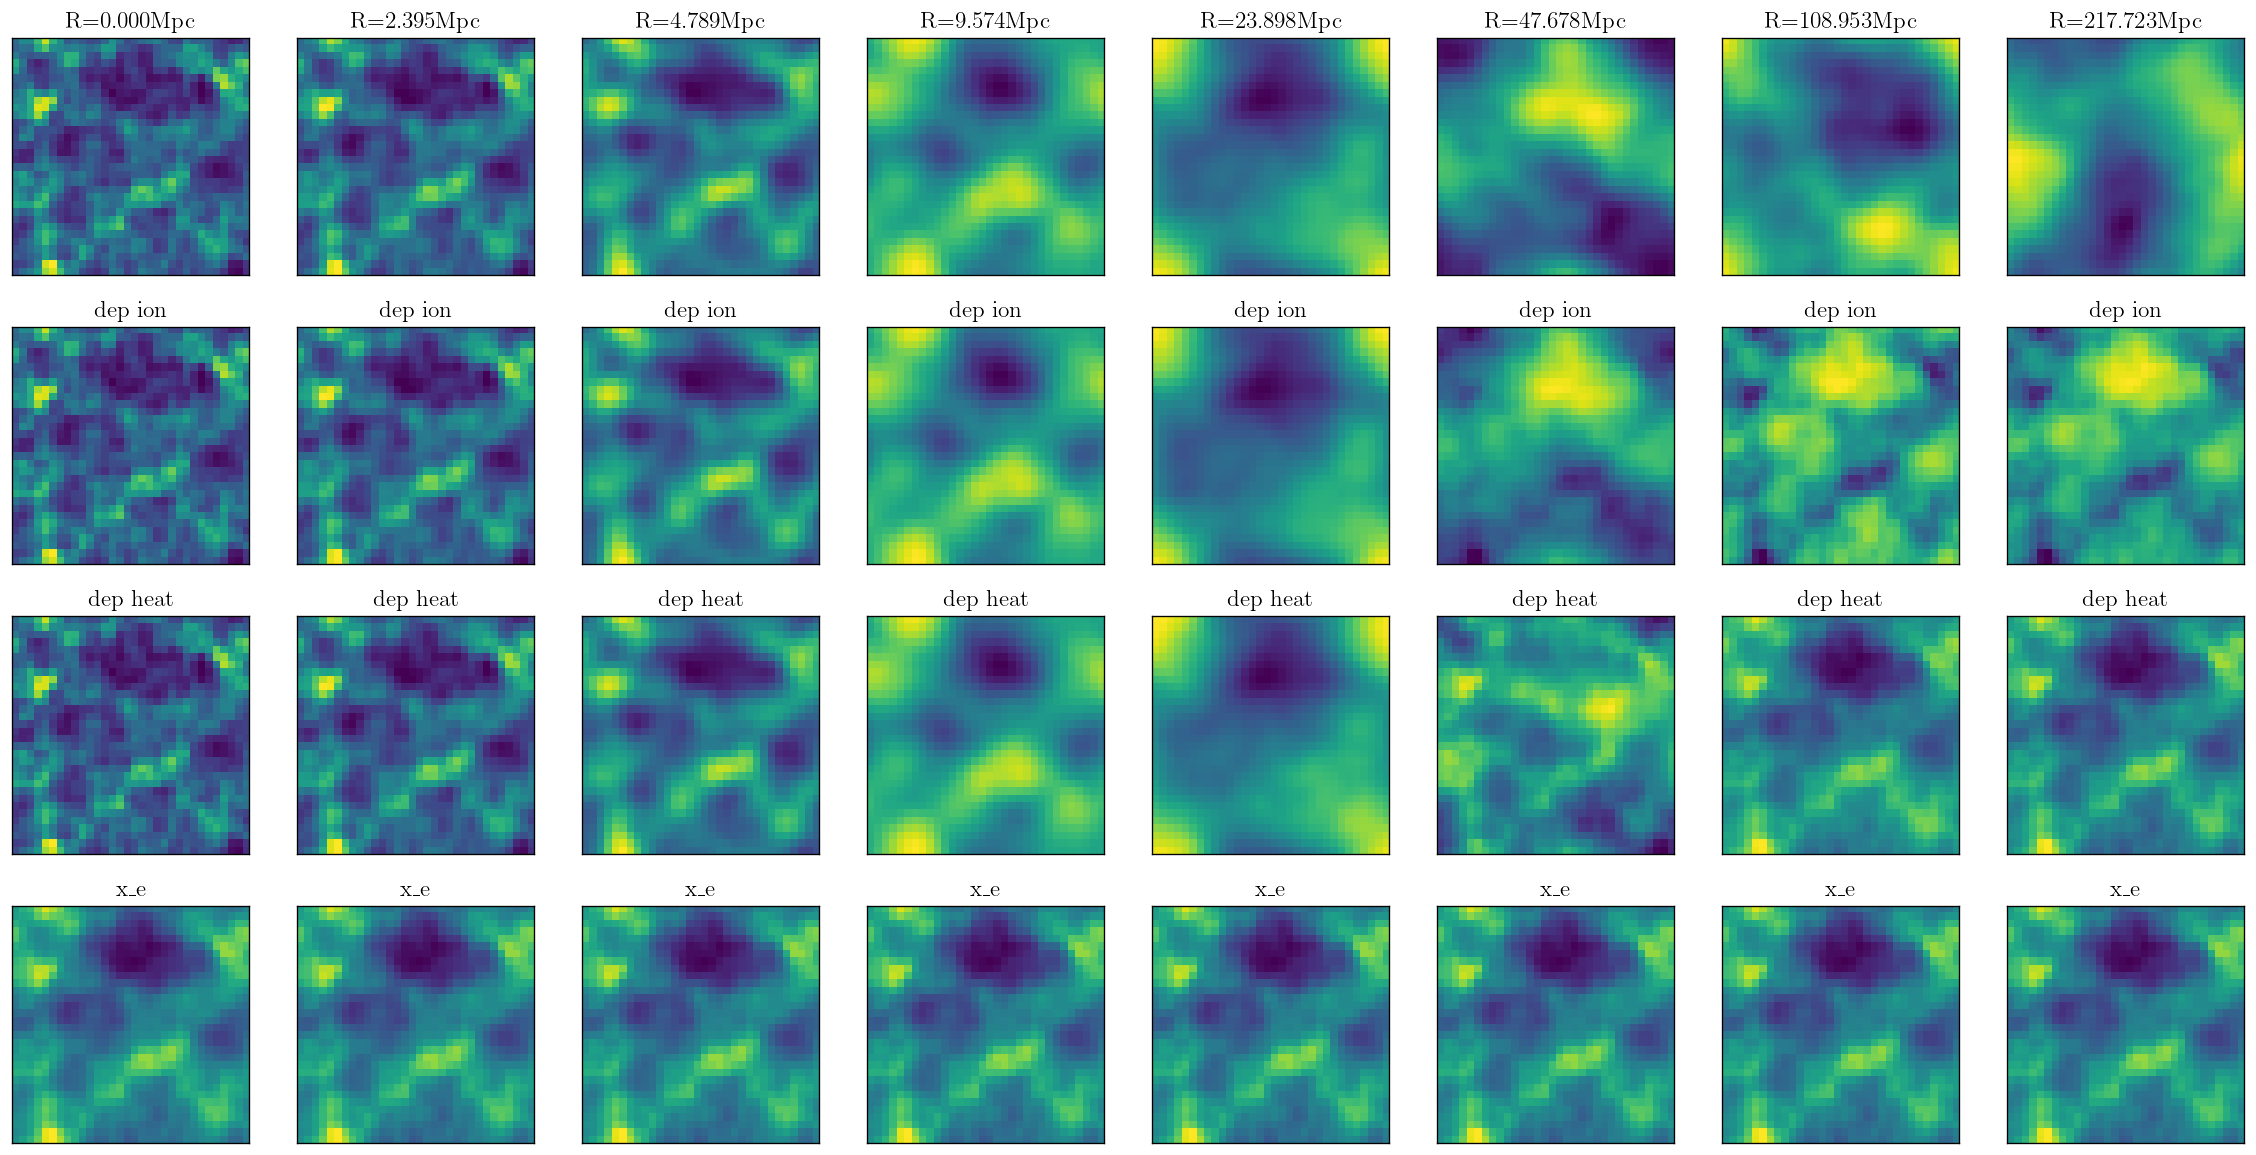

In [77]:
r_vals = r_vals_pc()
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for i, i_sh in zip(range(8), i_sh_views):
    ax = axs[0, i]
    ax.imshow(dep_tracker.deltas[i_sh][0], origin='lower')
    ax.set(title=f"R={dep_tracker.R_shells[i_sh]:.3f}Mpc")

    ax = axs[1, i]
    ax.imshow(dep_tracker.dep_Hion_shells[i_sh][0]+dep_tracker.dep_Heion_shells[i_sh][0], origin='lower')
    ax.set(title="dep ion")

    ax = axs[2, i]
    ax.imshow(dep_tracker.dep_heat_shells[i_sh][0], origin='lower')
    ax.set(title="dep heat")

    ax = axs[3, i]
    ax.imshow(x_e_box[0], origin='lower')
    ax.set(title='x_e')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])    

## Comparison: Total field

In [86]:
# check consistency
dep_ion_test = np.sum(spin_temp_next.DepIonBox, axis=0)
dep_ion_test_2 = spin_temp_next.x_e_box - spin_temp.x_e_box

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
ax = axs[0]
ax.imshow(dep_ion_test[0], origin='lower')
ax.set(title="dep ion")
ax = axs[1]
ax.imshow(dep_ion_test_2[0], origin='lower')
ax.set(title="x e change")
ax = axs[2]
im = ax.imshow(dep_ion_test[0]/dep_ion_test_2[0], origin='lower')
ax.set(title="ratio")
fig.colorbar(im, ax=ax)

In [96]:
pc_dep_ion = np.sum(spin_temp_next.DepIonBox, axis=0) * 1e5
dc_dep_ion = np.sum(dep_tracker.dep_Hion_shells, axis=0) / phys.rydberg + np.sum(dep_tracker.dep_Heion_shells, axis=0) / phys.He_ion_eng
dc_dep_ion /= phys.A_per_B
dc_dep_ion *= 1e5

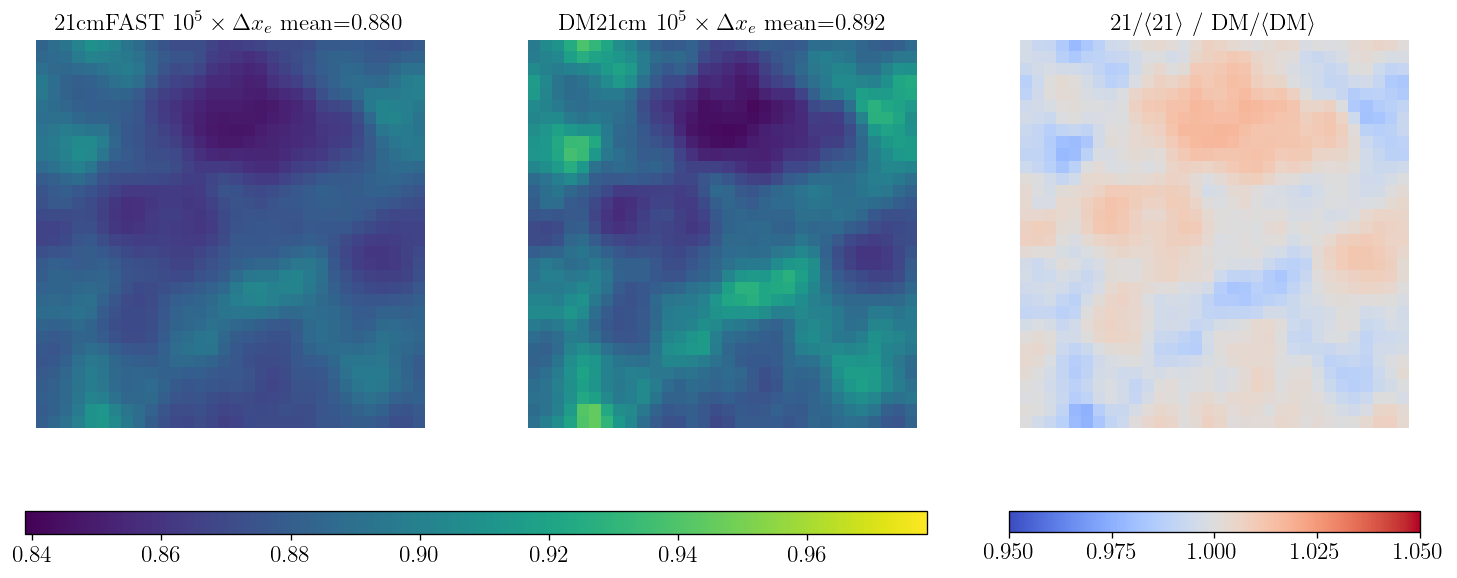

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

vmin = np.min([np.min(pc_dep_ion), np.min(dc_dep_ion)])
vmax = np.max([np.max(pc_dep_ion), np.max(dc_dep_ion)])

ax = axs[0]
im = ax.imshow(pc_dep_ion[0], origin='lower', vmin=vmin, vmax=vmax)
ax.set(title=rf"21cmFAST $10^5\times\Delta x_e$ mean={np.mean(pc_dep_ion):.3f}")
ax.axis('off')

ax = axs[1]
ax.imshow(dc_dep_ion[0], origin='lower', vmin=vmin, vmax=vmax)
ax.set(title=rf"DM21cm $10^5\times\Delta x_e$ mean={np.mean(dc_dep_ion):.3f}")
ax.axis('off')
fig.colorbar(im, ax=axs[:2], orientation='horizontal', aspect=40)

ax = axs[2]
ratio = pc_dep_ion[0]/dc_dep_ion[0]
im = ax.imshow(ratio/np.mean(ratio), origin='lower', vmin=0.95, vmax=1.05, cmap='coolwarm')
ax.set(title=rf"21/$\langle21\rangle$ / DM/$\langle$DM$\rangle$")
ax.axis('off')
fig.colorbar(im, ax=ax, orientation='horizontal')

In [108]:
pc_dep_heat = np.sum(spin_temp_next.DepHeatBox, axis=0)
dc_dep_heat = np.sum(dep_tracker.dep_heat_shells, axis=0) * 2 / (3*phys.kB*(1+x_e_box)) / phys.A_per_B

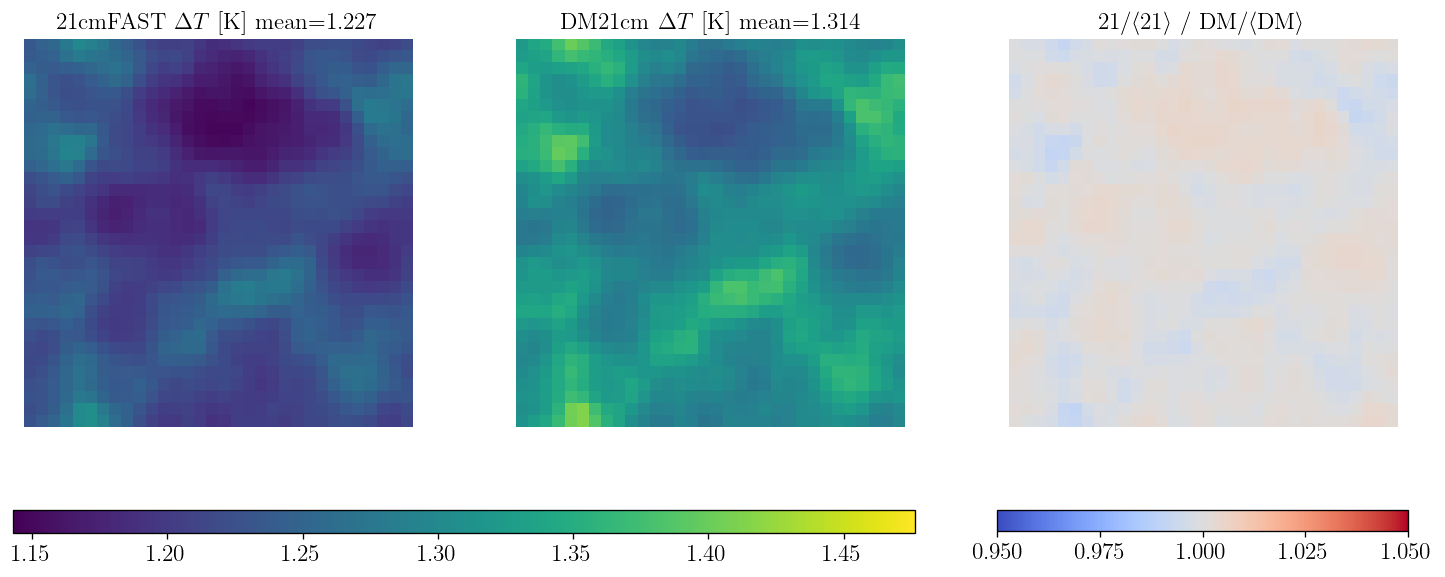

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

vmin = np.min([np.min(pc_dep_heat), np.min(dc_dep_heat)])
vmax = np.max([np.max(pc_dep_heat), np.max(dc_dep_heat)])

ax = axs[0]
im = ax.imshow(pc_dep_heat[0], origin='lower', vmin=vmin, vmax=vmax)
ax.set(title=rf"21cmFAST $\Delta T$ [K] mean={np.mean(pc_dep_heat):.3f}")
ax.axis('off')

ax = axs[1]
ax.imshow(dc_dep_heat[0], origin='lower', vmin=vmin, vmax=vmax)
ax.set(title=rf"DM21cm $\Delta T$ [K] mean={np.mean(dc_dep_heat):.3f}")
ax.axis('off')
fig.colorbar(im, ax=axs[:2], orientation='horizontal', aspect=40)

ax = axs[2]
ratio = pc_dep_heat[0]/dc_dep_heat[0]
im = ax.imshow(ratio/np.mean(ratio), origin='lower', vmin=0.95, vmax=1.05, cmap='coolwarm')
ax.set(title=rf"21/$\langle21\rangle$ / DM/$\langle$DM$\rangle$")
ax.axis('off')
fig.colorbar(im, ax=ax, orientation='horizontal')

In [141]:
pc_dep_ion_means = np.mean(spin_temp_next.DepIonBox, axis=(1, 2, 3)) * 1e5
dc_dep_ion_means = np.mean(np.array(dep_tracker.dep_Hion_shells), axis=(1, 2, 3)) / phys.rydberg \
                 + np.mean(np.array(dep_tracker.dep_Heion_shells), axis=(1, 2, 3)) / phys.He_ion_eng
dc_dep_ion_means /= phys.A_per_B
dc_dep_ion_means *= 1e5

pc_dep_heat_means = np.mean(spin_temp_next.DepHeatBox, axis=(1, 2, 3))
dc_dep_heat_means = np.mean(np.array(dep_tracker.dep_heat_shells) * 2 / (3*phys.kB*(1+x_e_box)) / phys.A_per_B, axis=(1, 2, 3))

In [126]:
def shell_dc(R_s, dep_s, dlogR=False):
    R_s_diff = R_s.copy()
    R_s_diff = np.insert(R_s_diff, 0, 2*R_s_diff[0] - R_s_diff[1])
    if dlogR:
        R_s_diff = np.log10(R_s_diff)
    return R_s, dep_s / np.abs(np.diff(R_s_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

def shell_pc(R_s, dep_s, dlogR=False):
    R_s_diff = R_s.copy()
    R_s_diff = np.insert(R_s_diff, 0, 0.)
    if dlogR:
        R_s_diff = np.append(R_s_diff, 2*R_s_diff[-1] - R_s_diff[-2])
        R_s_diff = np.log10((R_s_diff[1:] + R_s_diff[:-1]) / 2)
    return R_s, dep_s / np.abs(np.diff(R_s_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

/tmp/ipykernel_560605/2308074238.py:5: RuntimeWarning: divide by zero encountered in log10
  R_s_diff = np.log10(R_s_diff)


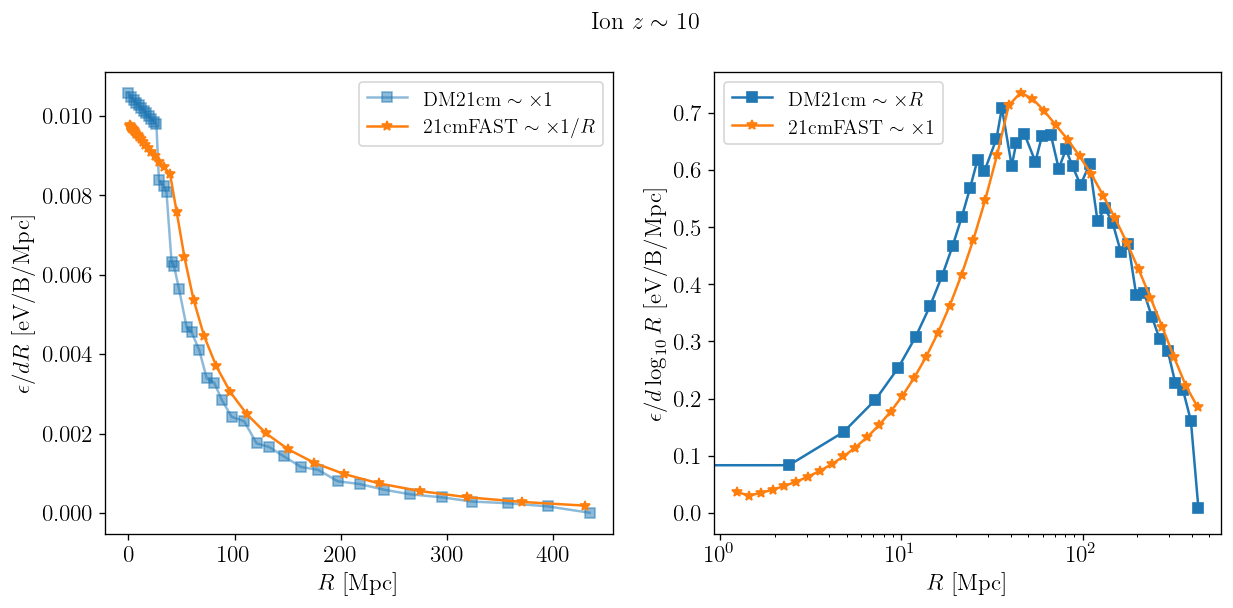

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.plot(*shell_dc(dep_tracker.R_shells, dc_dep_ion_means, dlogR=False), '-s', label=r'DM21cm $\sim\times1$', alpha=0.5)
ax.plot(*shell_pc(r_vals, pc_dep_ion_means, dlogR=False), '-*', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
ax.plot(*shell_dc(dep_tracker.R_shells, dc_dep_ion_means, dlogR=True), '-s', label=r'DM21cm $\sim\times R$')
ax.plot(*shell_pc(r_vals, pc_dep_ion_means, dlogR=True), '-*', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

fig.suptitle(rf"Ion $z \sim 10$");

/tmp/ipykernel_560605/2308074238.py:5: RuntimeWarning: divide by zero encountered in log10
  R_s_diff = np.log10(R_s_diff)


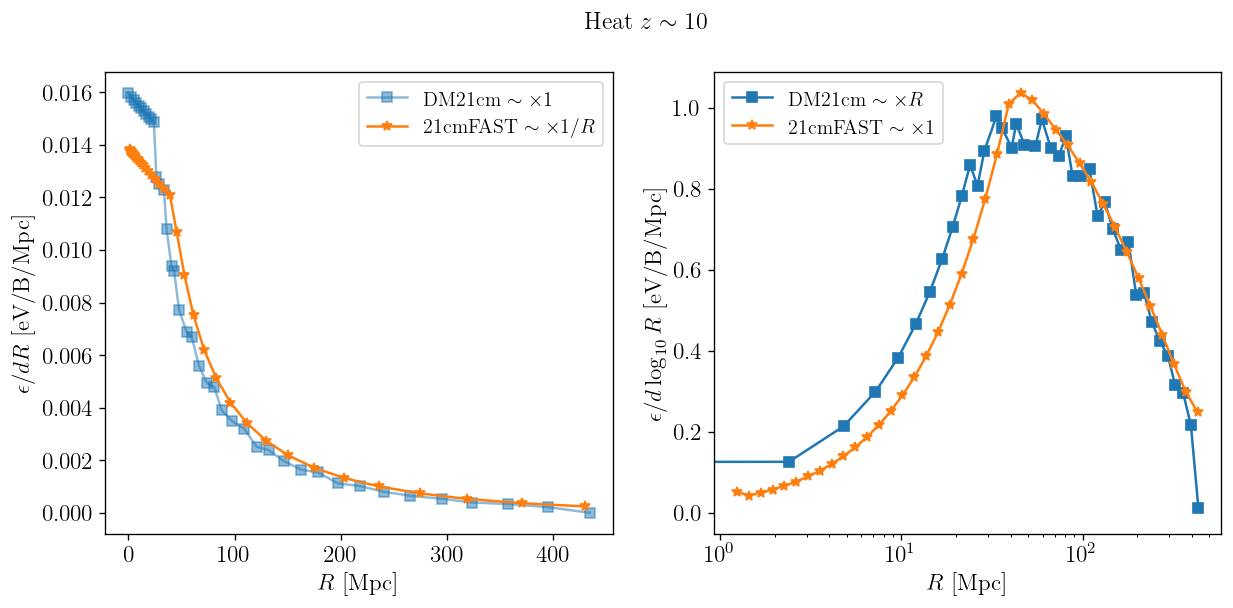

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.plot(*shell_dc(dep_tracker.R_shells, dc_dep_heat_means, dlogR=False), '-s', label=r'DM21cm $\sim\times1$', alpha=0.5)
ax.plot(*shell_pc(r_vals, pc_dep_heat_means, dlogR=False), '-*', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
ax.plot(*shell_dc(dep_tracker.R_shells, dc_dep_heat_means, dlogR=True), '-s', label=r'DM21cm $\sim\times R$')
ax.plot(*shell_pc(r_vals, pc_dep_heat_means, dlogR=True), '-*', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

fig.suptitle(rf"Heat $z \sim 10$");